# Using the 8 split datasets based on mass and jet number presence, we try ridge regression to predict outputs

## Dupplicate code from the dataset splitting

We have dupplicated it so as not to have git conflicts, but it should be the same with project1 - Alon.ipynb

In [194]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [196]:
def standardize(tx, mean = [], std = []):
    if len(mean) == 0:
        mean = np.mean(tx, axis=0)
    if len(std)==0:
        std = np.std(tx, axis=0)
        std[std==0] = 1 #if std = 0 it's actually ok to fix divide by 0 error
    tx = (tx-mean)/std
    return tx, mean, std

In [197]:
# remove features with error values
y_jet = []
tx_jet = []
y_jet_nm = []
tx_jet_nm = []
# filtering according to undefinition due to jet number
idx_jet_undef = [np.array([0,1,2,3,7,10,11,13,14,15,16,17,18,19,20,21,29]),
                np.array([0,1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24,25,29]),
                np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29]),
                np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])]

# Extra filtering according to definition of mass
idx_jet_undef_nm = [np.array([1,2,3,7,10,11,13,14,15,16,17,18,19,20,21,29]),
                    np.array([1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24,25,29]),
                    np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29]),
                    np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])]

for jet in range(4):
    idx_jet = (tX[:,22]==jet) & (tX[:,0] != -999)
    y_jet.append(y[idx_jet])
    tx_jet.append(tX[idx_jet][:,idx_jet_undef[jet]])
    # tx_jet.append(standardize(tX[idx_jet]))

for jet in range(4): # NB : no mass also has dupplicates from data that has mass, to have more data available for training.
    idx_jet = tX[:,22]==jet
    y_jet_nm.append(y[idx_jet])
    tx_jet_nm.append(tX[idx_jet][:,idx_jet_undef_nm[jet]])
    # tx_jet.append(standardize(tX[idx_jet]))

for jet in range(4):
    print('Jet {:} shape is {:}'.format(jet,tx_jet[jet].shape))
    print('Jet no mass {:} shape is {:}'.format(jet,tx_jet_nm[jet].shape))

Jet 0 shape is (73790, 17)
Jet no mass 0 shape is (99913, 16)
Jet 1 shape is (69982, 22)
Jet no mass 1 shape is (77544, 21)
Jet 2 shape is (47427, 29)
Jet no mass 2 shape is (50379, 28)
Jet 3 shape is (20687, 29)
Jet no mass 3 shape is (22164, 28)


## Put all data in a single 8 dim array

In [198]:
idx_col_select_split = idx_jet_undef
y_split = []
tx_split_non_std = []

for jet in range(4):
    idx_jet = (tX[:,22]==jet) & (tX[:,0] != -999)
    y_split.append(y[idx_jet])
    tx_split_non_std.append(tX[idx_jet][:,idx_jet_undef[jet]])

for jet in range(4): # NB : no mass also has dupplicates from data that has mass, to have more data available for training.
    idx_jet = tX[:,22]==jet
    y_split.append(y[idx_jet])
    tx_split_non_std.append(tX[idx_jet][:,idx_jet_undef_nm[jet]])
    
for jet in range(4):
    idx_col_select_split.append(idx_jet_undef_nm[jet])
    
# print(y_split)
# print(tx_split[0][0])
for set_i in range(8):
    print(f'Set {set_i} shape is {tx_split_non_std[set_i].shape}')

Set 0 shape is (73790, 17)
Set 1 shape is (69982, 22)
Set 2 shape is (47427, 29)
Set 3 shape is (20687, 29)
Set 4 shape is (99913, 16)
Set 5 shape is (77544, 21)
Set 6 shape is (50379, 28)
Set 7 shape is (22164, 28)


## Standardize the data

In [199]:
tx_split = []
train_set_means = []
train_set_stds = []
for tx in tx_split_non_std:
    tx_set, set_means, set_stds = standardize(tx)
    train_set_means.append(set_means)
    train_set_stds.append(set_stds)
    tx_split.append(tx_set)
    
print(train_set_means[0])
print(train_set_stds[0])

[ 1.20667654e+02  4.94677127e+01  8.60007708e+01  1.48237433e+01
  2.89791012e+00  1.37458807e+00 -7.74707033e-01  3.48042406e+01
 -1.96553191e-02 -2.79592492e-02  4.28319566e+01 -4.29962597e-02
  4.13777612e-02  2.42637276e+01 -1.74490175e-02  1.31144570e+02
  0.00000000e+00]
[51.74971089 29.19233974 35.15751624 17.76503391  0.49640359  0.57386398
  1.0476136  14.58676056  1.22306217  1.8161881  14.23136702  1.29174406
  1.81594632 16.25671028  1.81313065 52.83481881  1.        ]


## Ridge regression implementation for this set

For each of the datasets, we now have to train a model. We will use ridge regression, with different lambdas to find the best one. We use a high polynomial expansion because optimising for lambda should mean that any high degree will be compensated by the ridge regression when optimised. Therefore we use any high degree that guarantees our model is not limited by it's complexity.

In [200]:
from lab3_plots import plot_train_test
from th_helpers import build_poly, split_data, compute_rmse
from th_ridge_regression import ridge_regression

In [201]:
def ridge_regression_lambdas(x, y, degree, ratio, seed, lambdas):#=np.logspace(-5, 0, 15)):
    """Performs ridge regression with multiple lambdas."""
    # split the data, and return train and test data: TODO
    train_x, train_y, test_x, test_y = split_data(x, y, ratio, seed)

    # form train and test data with polynomial basis function: TODO
    train_x_aug = build_poly(train_x, degree)
    test_x_aug = build_poly(test_x, degree)

    rmse_tr = []
    rmse_te = []
    
    min_w_te = []
    min_rmse_te = -1
    best_lambda = False
    best_correctness = -1
    
    for ind, lambda_ in enumerate(lambdas):

        # ridge regression with a given lambda        
        w = ridge_regression(train_y, train_x_aug, lambda_)
        
        rmse_tr.append(compute_rmse(train_y, train_x_aug, w))
        rmse_te.append(compute_rmse(test_y, test_x_aug, w))
        
        if rmse_te[ind] < min_rmse_te or min_rmse_te == -1:
            min_rmse_te = rmse_te[ind]
            min_w_te = w
            best_lambda = lambda_
            
        # ***************************************************
#         print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
#                p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    
    # Compute correctness of best result 
    y_out_test = np.dot(test_x_aug, min_w_te)
    y_out_test[y_out_test>=0] = 1
    y_out_test[y_out_test<0] = -1
    best_correctness = 100*(y_out_test == test_y).tolist().count(True)/y_out_test.shape[0]
            
    # Plot the obtained results
    print(f"Degree={degree}, ratio={np.round(ratio, 3)}, seed={seed}, min test RMSE={np.round(min_rmse_te, 4)}, with correctness={np.round(best_correctness, 2)}% ({len(y_out_test)} test points) and lambda={np.round(best_lambda, 7)}")
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    
    return min_rmse_te, min_w_te, best_lambda, best_correctness

# THEOTEST code
# ridge_regression_demo(x=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).T, 
#                       y=np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]).T,
#                       degree = 3,
#                       ratio = 0.7,
#                       seed = 56)


Analysing set=0, degree=6
Degree=6, ratio=0.9, seed=150, min test RMSE=0.7421, with correctness=80.72% (7379 test points) and lambda=0.0


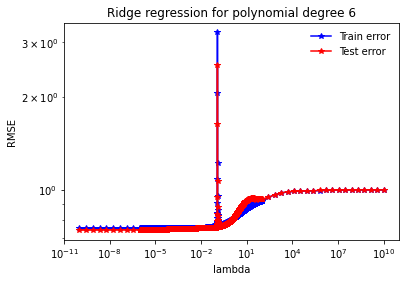

 Set=0 correctness improved degree=6, test correctness=80.72%, for lambda=0.0

Analysing set=0, degree=7
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7436, with correctness=80.73% (7379 test points) and lambda=0.0107156


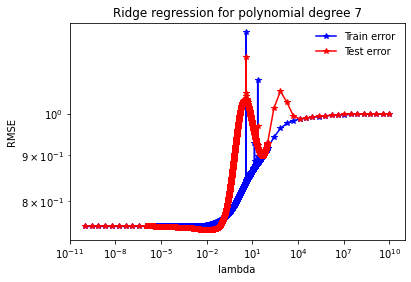

 Set=0 correctness improved degree=7, test correctness=80.73%, for lambda=0.0107156

Analysing set=0, degree=8
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7429, with correctness=80.73% (7379 test points) and lambda=0.0426889


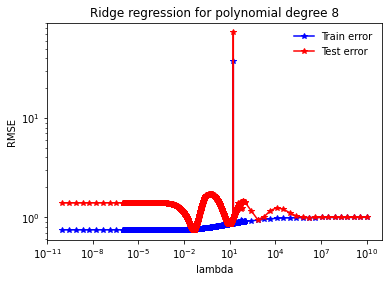


Analysing set=0, degree=9
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7372, with correctness=80.95% (7379 test points) and lambda=0.0137426


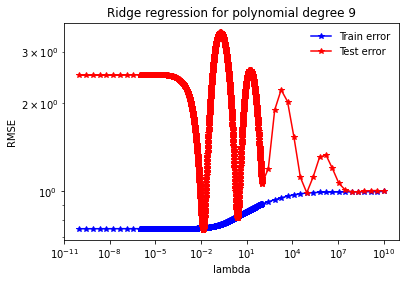

 Set=0 correctness improved degree=9, test correctness=80.95%, for lambda=0.0137426

Analysing set=1, degree=6
Degree=6, ratio=0.9, seed=150, min test RMSE=0.8085, with correctness=77.18% (6998 test points) and lambda=0.0002154


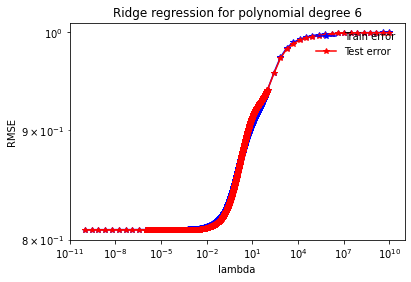

 Set=1 correctness improved degree=6, test correctness=77.18%, for lambda=0.0002154

Analysing set=1, degree=7
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7977, with correctness=77.99% (6998 test points) and lambda=0.0018435


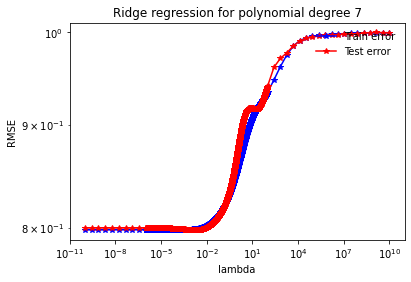

 Set=1 correctness improved degree=7, test correctness=77.99%, for lambda=0.0018435

Analysing set=1, degree=8
Degree=8, ratio=0.9, seed=150, min test RMSE=0.786, with correctness=79.31% (6998 test points) and lambda=1.59e-05


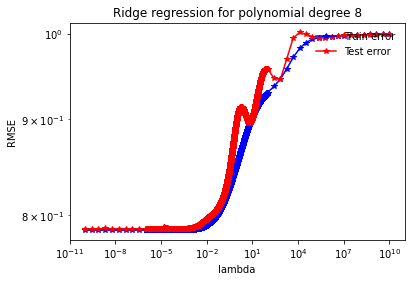

 Set=1 correctness improved degree=8, test correctness=79.31%, for lambda=1.59e-05

Analysing set=1, degree=9
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7785, with correctness=79.54% (6998 test points) and lambda=0.000156


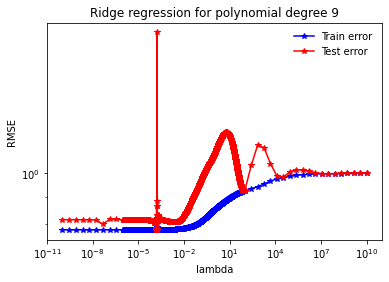

 Set=1 correctness improved degree=9, test correctness=79.54%, for lambda=0.000156

Analysing set=2, degree=6
Degree=6, ratio=0.9, seed=150, min test RMSE=0.7637, with correctness=81.07% (4743 test points) and lambda=0.0095938


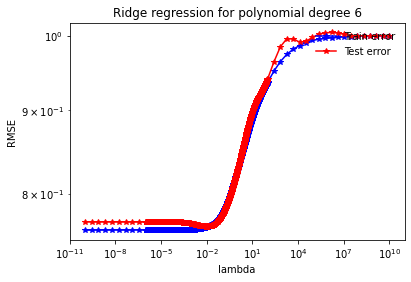

 Set=2 correctness improved degree=6, test correctness=81.07%, for lambda=0.0095938

Analysing set=2, degree=7
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7521, with correctness=81.85% (4743 test points) and lambda=0.0128841


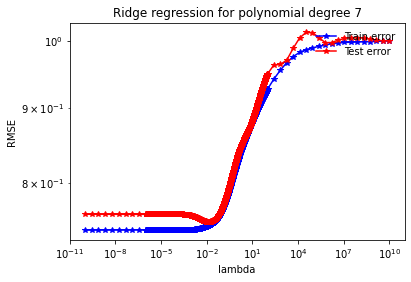

 Set=2 correctness improved degree=7, test correctness=81.85%, for lambda=0.0128841

Analysing set=2, degree=8
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7365, with correctness=82.77% (4743 test points) and lambda=0.0056738


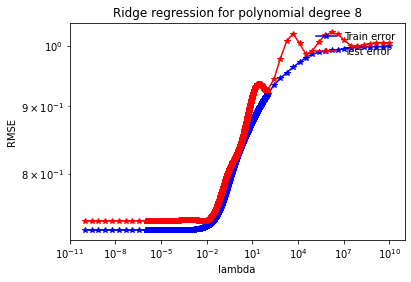

 Set=2 correctness improved degree=8, test correctness=82.77%, for lambda=0.0056738

Analysing set=2, degree=9
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7289, with correctness=83.11% (4743 test points) and lambda=0.0


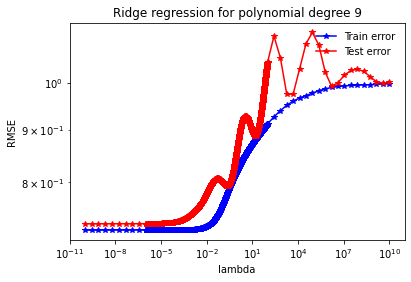

 Set=2 correctness improved degree=9, test correctness=83.11%, for lambda=0.0

Analysing set=3, degree=6
Degree=6, ratio=0.9, seed=150, min test RMSE=0.8104, with correctness=79.85% (2069 test points) and lambda=0.0047189


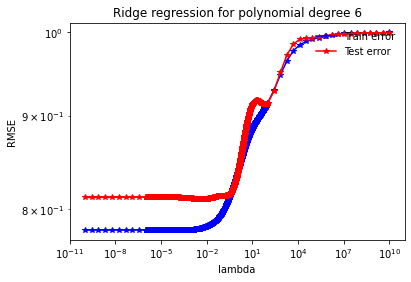

 Set=3 correctness improved degree=6, test correctness=79.85%, for lambda=0.0047189

Analysing set=3, degree=7
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7634, with correctness=80.72% (2069 test points) and lambda=0.0


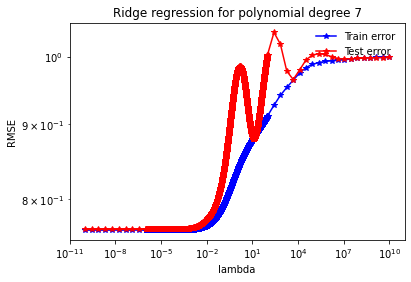

 Set=3 correctness improved degree=7, test correctness=80.72%, for lambda=0.0

Analysing set=3, degree=8
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7606, with correctness=81.54% (2069 test points) and lambda=0.0095058


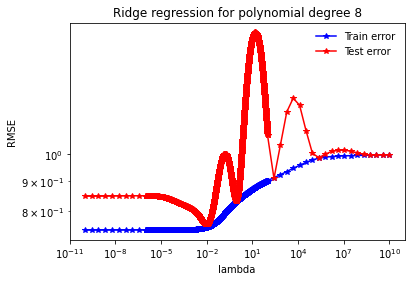

 Set=3 correctness improved degree=8, test correctness=81.54%, for lambda=0.0095058

Analysing set=3, degree=9
Degree=9, ratio=0.9, seed=150, min test RMSE=0.8119, with correctness=77.91% (2069 test points) and lambda=0.2161063


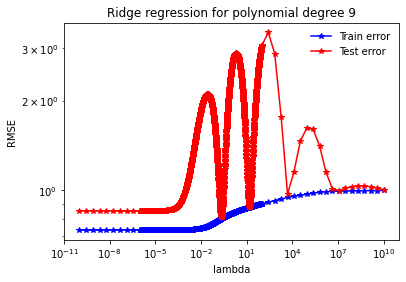


Analysing set=4, degree=6
Degree=6, ratio=0.9, seed=150, min test RMSE=0.6963, with correctness=83.59% (9991 test points) and lambda=0.0


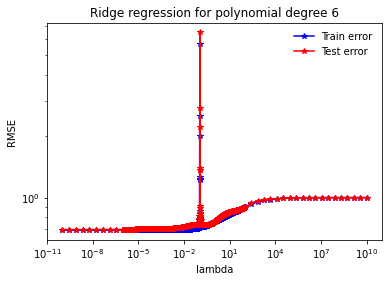

 Set=4 correctness improved degree=6, test correctness=83.59%, for lambda=0.0

Analysing set=4, degree=7
Degree=7, ratio=0.9, seed=150, min test RMSE=0.6926, with correctness=83.45% (9991 test points) and lambda=0.0179526


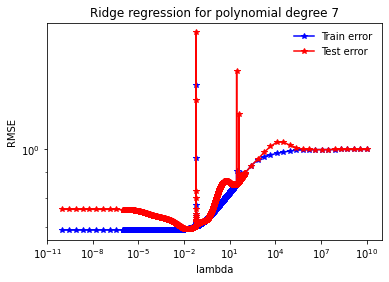


Analysing set=4, degree=8
Degree=8, ratio=0.9, seed=150, min test RMSE=0.6955, with correctness=83.47% (9991 test points) and lambda=0.0326781


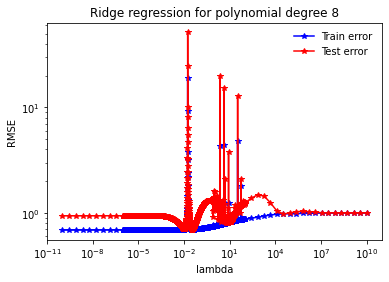


Analysing set=4, degree=9
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7015, with correctness=83.93% (9991 test points) and lambda=0.000191


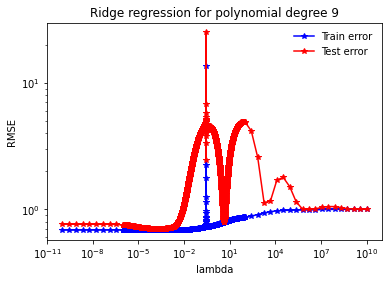

 Set=4 correctness improved degree=9, test correctness=83.93%, for lambda=0.000191

Analysing set=5, degree=6
Degree=6, ratio=0.9, seed=150, min test RMSE=0.8068, with correctness=77.26% (7754 test points) and lambda=0.0027652


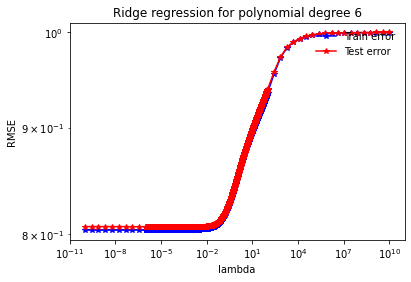

 Set=5 correctness improved degree=6, test correctness=77.26%, for lambda=0.0027652

Analysing set=5, degree=7
Degree=7, ratio=0.9, seed=150, min test RMSE=0.8063, with correctness=77.12% (7754 test points) and lambda=2.9e-06


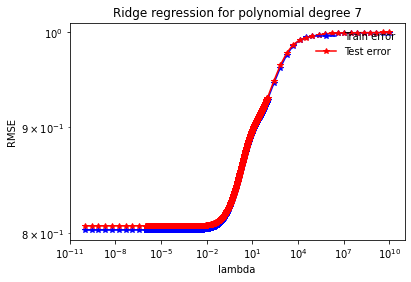


Analysing set=5, degree=8
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7994, with correctness=77.87% (7754 test points) and lambda=0.0024082


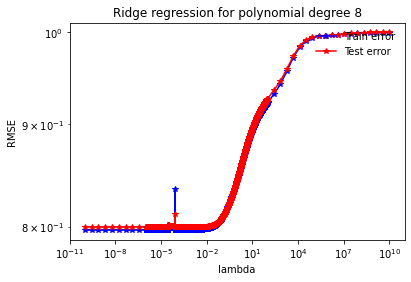

 Set=5 correctness improved degree=8, test correctness=77.87%, for lambda=0.0024082

Analysing set=5, degree=9
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7936, with correctness=78.18% (7754 test points) and lambda=0.0016967


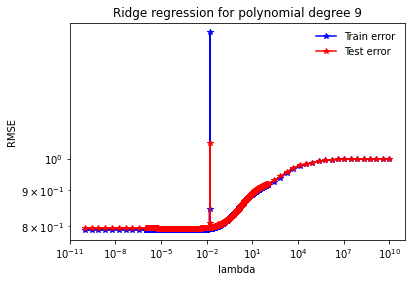

 Set=5 correctness improved degree=9, test correctness=78.18%, for lambda=0.0016967

Analysing set=6, degree=6
Degree=6, ratio=0.9, seed=150, min test RMSE=0.789, with correctness=79.1% (5038 test points) and lambda=0.0


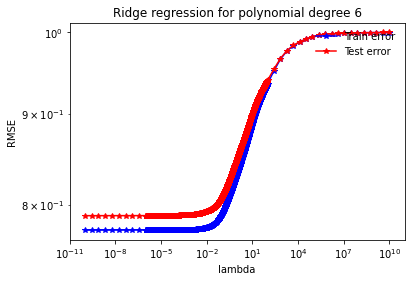

 Set=6 correctness improved degree=6, test correctness=79.1%, for lambda=0.0

Analysing set=6, degree=7
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7875, with correctness=78.84% (5038 test points) and lambda=0.0


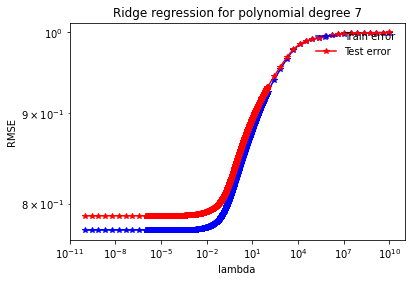


Analysing set=6, degree=8
Degree=8, ratio=0.9, seed=150, min test RMSE=0.7894, with correctness=79.42% (5038 test points) and lambda=0.0013601


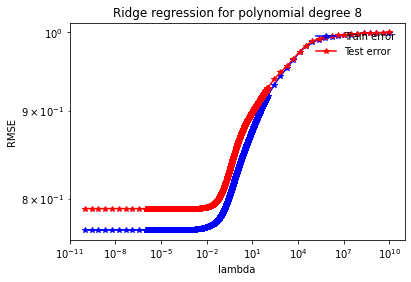

 Set=6 correctness improved degree=8, test correctness=79.42%, for lambda=0.0013601

Analysing set=6, degree=9
Degree=9, ratio=0.9, seed=150, min test RMSE=0.7832, with correctness=79.77% (5038 test points) and lambda=0.0


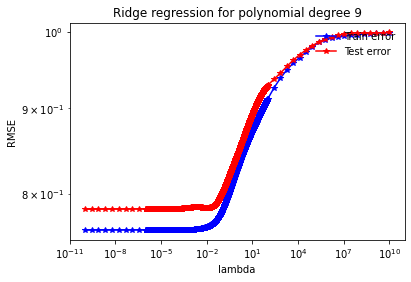

 Set=6 correctness improved degree=9, test correctness=79.77%, for lambda=0.0

Analysing set=7, degree=6
Degree=6, ratio=0.9, seed=150, min test RMSE=0.7768, with correctness=79.96% (2216 test points) and lambda=0.0021962


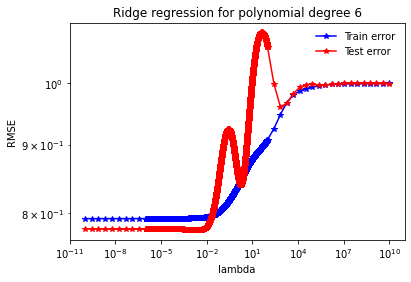

 Set=7 correctness improved degree=6, test correctness=79.96%, for lambda=0.0021962

Analysing set=7, degree=7
Degree=7, ratio=0.9, seed=150, min test RMSE=0.7976, with correctness=79.42% (2216 test points) and lambda=0.0


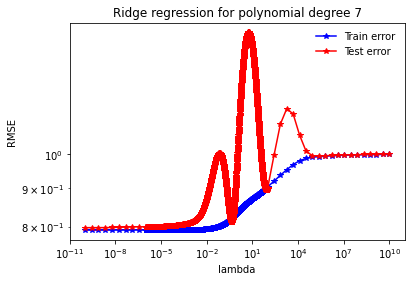


Analysing set=7, degree=8
Degree=8, ratio=0.9, seed=150, min test RMSE=0.786, with correctness=78.7% (2216 test points) and lambda=0.0682995


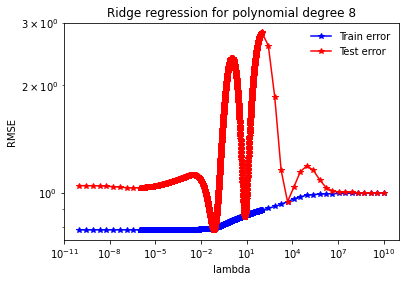


Analysing set=7, degree=9
Degree=9, ratio=0.9, seed=150, min test RMSE=0.774, with correctness=79.96% (2216 test points) and lambda=0.0208046


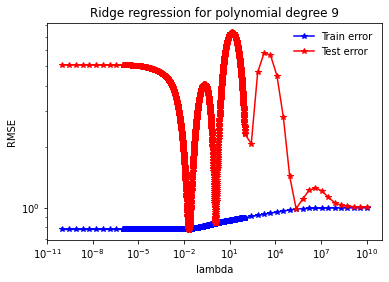



Final best correctness=[80.94592763247053, 79.53701057444984, 83.11195445920303, 81.53697438376027, 83.92553297968172, 78.17900438483363, 79.77371973005161, 79.96389891696751], 
 degrees=[9, 9, 9, 8, 9, 9, 9, 6], 
  lambdas=[0.013742604071314312, 0.0001559899246446727, 1e-10, 0.009505807045841162, 0.00019104715304561865, 0.0016967380821661137, 1e-10, 0.00219619468116618]


In [80]:
seed = 150
degree = 8
degrees = [degree+6 for degree in range(4)]
split_ratio = 0.9
lambdas = np.concatenate((np.logspace(-10, -6, 10), np.logspace(-6, 2, 2000), np.logspace(2, 10, 20)))
best_degrees_hyp = 8*[0]
best_lambdas_hyp = 8*[-1]
best_correctness_hyp = 8*[-1]
best_ws_split = [8*[]] # To check whether predictions from training on split set is better than whole set 

for set_i in range(8):
    for degree in degrees:
        print(f"\nAnalysing set={set_i}, degree={degree}")
        _, best_w_split, best_lambda, best_correctness = ridge_regression_lambdas(tx_split[set_i], y_split[set_i], degree, split_ratio, seed, lambdas)
        
        if best_correctness > best_correctness_hyp[set_i]:
            best_correctness_hyp[set_i] = best_correctness
            best_lambdas_hyp[set_i] = best_lambda
            best_degrees_hyp[set_i] = degree
            #best_ws_split[set_i]=best_w_split
            print(f"\x1B[42m Set={set_i} correctness improved degree={degree}, test correctness={np.round(best_correctness, 2)}%, for lambda={np.round(best_lambda, 7)}\x1B[0m")

print(f"\n\nFinal best correctness={best_correctness_hyp}, \n degrees={best_degrees_hyp}, \n  lambdas={best_lambdas_hyp}")            


## Investigations into specific sets :

### Set 7

In [ ]:
seed = 150
degree = 7
split_ratio = 0.9
lambdas = np.logspace(-5, 10, 1000)

set_i = 7

print(f"\nAnalysing set={set_i}")
min_rmse_te, min_w_te, best_lambda = ridge_regression_lambdas(tx_split[set_i], y_split[set_i], degree, split_ratio, seed, lambdas)

## Now actual ridge regression with output file

We need to split the test data the same way, but keeping the ids in order to reconstruct it afterwards.

In [202]:
# parameters chosen from above tests
best_degrees = [9, 9, 9, 8, 9, 9, 9, 6]
best_lambdas = [0.013742604071314312, 0.0001559899246446727, 1e-10, 0.009505807045841162, 0.00019104715304561865, 0.0016967380821661137, 1e-10, 0.00219619468116618]
print(best_degrees, best_lambdas)

[9, 9, 9, 8, 9, 9, 9, 6] [0.013742604071314312, 0.0001559899246446727, 1e-10, 0.009505807045841162, 0.00019104715304561865, 0.0016967380821661137, 1e-10, 0.00219619468116618]


We will first re-train our 8 models on the whole data, with the parameters found. As we checked for the best model complexity still avoiding overfitting, we will now train on all the train data. Because this is increasing the data on which the model trains, it should in fact reduce overfitting since we keep the same, therefore we do not split the data to check. We will in any case have AIcrowd to indicate if that was a good choice or not.

After getting the model for each set, we will go through the original set and predict the outcome. We do this by iterating as we want to keep the right id for each datapoint.

In [203]:
set_ws = []
for set_i in range(8):    
    train_x_aug = build_poly(tx_split[set_i], best_degrees[set_i])
    set_ws.append( ridge_regression(y_split[set_i], train_x_aug, best_lambdas[set_i]) )
    print(f"train_x_aug shape={train_x_aug.shape} w_shape={set_ws[set_i].shape}")

train_x_aug shape=(73790, 154) w_shape=(154,)
train_x_aug shape=(69982, 199) w_shape=(199,)
train_x_aug shape=(47427, 262) w_shape=(262,)
train_x_aug shape=(20687, 233) w_shape=(233,)
train_x_aug shape=(99913, 145) w_shape=(145,)
train_x_aug shape=(77544, 190) w_shape=(190,)
train_x_aug shape=(50379, 253) w_shape=(253,)
train_x_aug shape=(22164, 169) w_shape=(169,)


In [204]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test_unstd, ids_test = load_csv_data(DATA_TEST_PATH)

In [205]:
print(tX_test_unstd.shape)

(568238, 30)


Standardize the test data using averages and means from the train data

In [206]:
tX_test = np.empty(tX_test_unstd.shape)
for point_i, datapoint in enumerate(tX_test_unstd):
    jet_num = int(datapoint[22])
    if datapoint[0] != -999: # Mass is defined
        std_datapoint, _, _ = standardize(tX_test[point_i][idx_jet_undef[jet_num]], train_set_means[jet_num], train_set_stds[jet_num])
        tX_test[point_i][idx_jet_undef[jet_num]] = std_datapoint
    else : # Mass is undefined
        std_datapoint, _, _ = standardize(tX_test[point_i][idx_jet_undef[jet_num+4]], train_set_means[jet_num+4], train_set_stds[jet_num+4])
        tX_test[point_i][idx_jet_undef[jet_num+4]] = std_datapoint
        
print(tX_test.shape)
print(tX_test_unstd.shape)

(568238, 30)
(568238, 30)


Standardize the train set as a whole

In [207]:
tX_train_std = np.empty(tX.shape)
for point_i, datapoint in enumerate(tX):
    jet_num = int(datapoint[22])
    if datapoint[0] != -999: # Mass is defined
        std_datapoint, _, _ = standardize(tX[point_i][idx_jet_undef[jet_num]], train_set_means[jet_num], train_set_stds[jet_num])
        tX_train_std[point_i][idx_jet_undef[jet_num]] = std_datapoint
    else : # Mass is undefined
        std_datapoint, _, _ = standardize(tX[point_i][idx_jet_undef[jet_num+4]], train_set_means[jet_num+4], train_set_stds[jet_num+4])
        tX_train_std[point_i][idx_jet_undef[jet_num+4]] = std_datapoint
        
print(tX.shape)
print(tX_train_std.shape)

(250000, 30)
(250000, 30)


Now predict the outputs

In [210]:
def compute_out_y(tX, ws, degrees, non_std_tX):
    y_out = np.empty(tX.shape[0])

    for point_i, datapoint in enumerate(tX):
        jet_num = int(non_std_tX[point_i][22])
        if datapoint[0] != -999: # Mass is defined
            correct_set = datapoint[idx_jet_undef[jet_num]]
            correct_set_aug = build_poly(correct_set, degrees[jet_num])
            y_out[point_i] = np.dot(correct_set_aug, ws[jet_num])
        else : # Mass is undefined
            correct_set = datapoint[idx_jet_undef_nm[jet_num]]
            correct_set_aug = build_poly(correct_set, degrees[jet_num+4]) # offset of 4 because no mass ws start at index 4
            y_out[point_i] = np.dot(correct_set_aug, ws[jet_num+4])         

    y_out[y_out>=0] = 1
    y_out[y_out<0] = -1  
    
    return y_out

In [211]:
y_out_train_check = compute_out_y(tX_train_std, set_ws, best_degrees, tX)

print(f"Correctness for all train set={100*(y_out_train_check == y).tolist().count(True)/y_out_train_check.shape[0]}%")

Correctness for all train set=82.0576%


Now apply to test set and generate csv file

In [212]:
y_out_test = compute_out_y(tX_test, set_ws, best_degrees, tX_test_unstd )
print(f"Y test out shape={y_out_test.shape} and original tX_test shape={tX_test.shape}")

Y test out shape=(568238,) and original tX_test shape=(568238, 30)


In [213]:
LAST_OUT_NAME = f"submit_ridge_split8sets_standardized.csv"
create_csv_submission(ids_test, y_out_test, LAST_OUT_NAME)
print("Correctly created file with name=", LAST_OUT_NAME)

Correctly created file with name= submit_ridge_split8sets_standardized.csv
